# Variational Inference for Mixtures of PCAs

The variational inference approach to mixtures of probabilistic principal component analysis.

## 2D Mixture of Gaussians
### Generating Data


In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from scipy.stats import multivariate_normal as mvn
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from mpl_toolkits.mplot3d import axes3d, Axes3D

def sample(pi, mean, cov, n):
    samples = np.array([]).reshape(mean[0].shape[0],0)
    category = np.array([]).reshape(1,0)
    for i in range(n):
        m = np.random.choice(range(pi.size), p=pi)
        sample_n = np.random.multivariate_normal(mean[m], cov[m], 1).T
        samples = np.c_[samples, sample_n]
        category = np.append(category, m)     
    return samples, category


Next, I plot the Gaussian mixture distribution, draw some samples form it and make a scatter plot.

Text(0.5,1,'True Distribution and Sampled Data Points')

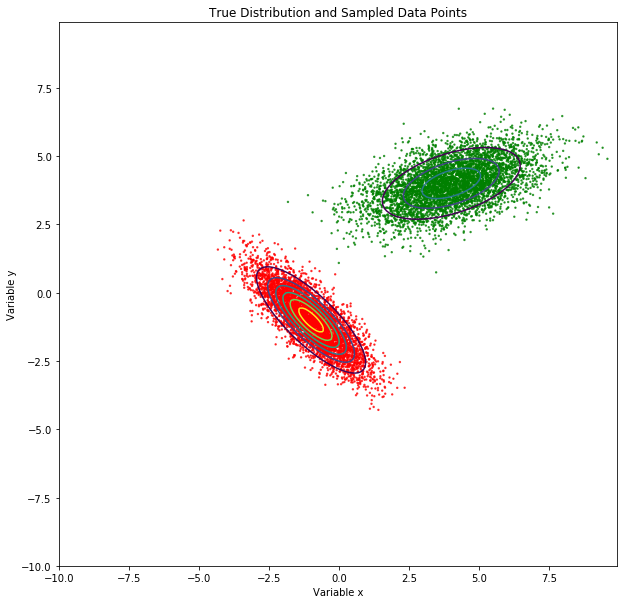

In [10]:
pi = np.array([30, 30]) / 60
mean = np.array([[-1,-1], [4, 4]])
cov = np.array([[[1, -0.8],[-0.8, 1]], [[1.5**2, 0.6], [0.6, 0.8**2]]])

X = np.arange(-10, 10, 0.1)
Y = np.arange(-10, 10, 0.1)
x, y = np.meshgrid(X, Y)

g1 = mlab.bivariate_normal(x, y, 1.0, 1.0, -1, -1, -0.8)
g2 = mlab.bivariate_normal(x, y, 1.5, 0.8, 4, 4, 0.6)
g = pi[0] * g1 + pi[1] * g2


samples, category = sample(pi, mean, cov, 10000)

c = ['r' if i == 0 else 'g' for i in category]
fig = plt.figure(figsize=(10, 10))
cs = plt.contour(x,y,g)
plt.scatter(samples[0], samples[1],alpha=0.7, s=2, color=c)


plt.xlabel('Variable x')
plt.ylabel('Variable y')
plt.title('True Distribution and Sampled Data Points')

### Running Variational Inference for Mixtures of PPCAs

Now, I feed the sampled points to the algorithm.

In [11]:
import sys
sys.path.append('..')
import mbpca
from scipy.stats import multivariate_normal

Now I create an object which will do the fitting and I specify 5 mixture components. Note - that is more than what is really needed.

In [24]:
mbpca_dist = mbpca.MVBPCA(samples, 5)
mbpca_dist.fit(10000,100, eps=1e-4, verbose=True, init=True)

 Iteration: 0
 Lower bound: -17987052.45
 Iteration: 1
 Lower bound: -90247.24
 Iteration: 2
 Lower bound: -79823.40
 Iteration: 3
 Lower bound: -72018.82
 Iteration: 4
 Lower bound: -65794.23
 Iteration: 5
 Lower bound: -60931.76
 Iteration: 6
 Lower bound: -56965.24
 Iteration: 7
 Lower bound: -53888.28
 Iteration: 8
 Lower bound: -51784.69
 Iteration: 9
 Lower bound: -50121.34
 Iteration: 10
 Lower bound: -48693.62
 Iteration: 11
 Lower bound: -47487.17
 Iteration: 12
 Lower bound: -46530.23
 Iteration: 13
 Lower bound: -45813.92
 Iteration: 14
 Lower bound: -45281.45
 Iteration: 15
 Lower bound: -44881.82
 Iteration: 16
 Lower bound: -44578.04
 Iteration: 17
 Lower bound: -44340.74
 Iteration: 18
 Lower bound: -44147.80
 Iteration: 19
 Lower bound: -44008.05
 Iteration: 20
 Lower bound: -43902.29
 Iteration: 21
 Lower bound: -43819.61
 Iteration: 22
 Lower bound: -43754.66
 Iteration: 23
 Lower bound: -43703.14
 Iteration: 24
 Lower bound: -43661.80
 Iteration: 25
 Lower bound: -43

Here I create a function which calculates contoures of all of the mixtures found

In [25]:
def create_contours(mbpca_dist,x_min,x_max, y_min, y_max, figx,figy, plot=False):
    m = mbpca_dist.q_w.M
    Wm = [mbpca_dist.q_w.mean[m] for m in range(mbpca_dist.q_w.M)]
    Cm = [np.identity(w.shape[0]) / mbpca_dist.q_tau.e_tau + w @ w.T for w in Wm] # Covariance matrix for marginal distribution of x
    mean = [mbpca_dist.q_mu.mean[:,[i]].reshape(2,) for i in range(mbpca_dist.q_mu.M)]
    
    x, y = np.mgrid[x_min:x_max:.01, y_min:y_max:.01]
    pos = np.dstack((x, y))
    
    g = multivariate_normal(mean[0], Cm[0])
    s = mbpca_dist.q_pi.e_pi[0]*g.pdf(pos)
    s_tot = s
    fig2 = plt.figure(figsize=(figx, figy))
    if plot:
        plt.contour(x,y,s)
    for i in range(1, m):
        if mbpca_dist.q_pi.e_pi[i]>0.001:
            g = multivariate_normal(mean[i], Cm[i])
            s = mbpca_dist.q_pi.e_pi[i]*g.pdf(pos)
            s_tot += s
            if plot:
                plt.contour(x,y,s)
            
    return (x, y, s_tot)       

### Results


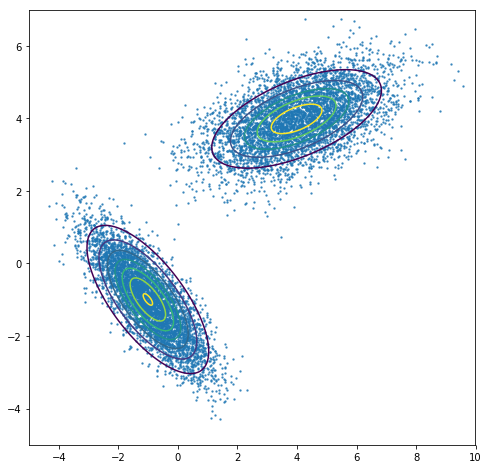

In [26]:
(x, y, s_tot) = create_contours(mbpca_dist,-5,10,-5,7,8, 8, True)
plt.scatter(samples[0], samples[1], alpha=0.7, s=2)

Here we have the pi parameters which tell us how responsible each mixture is for generating the data points.

In [28]:
print(['%0.2f %%' % (pi*100) for pi in mbpca_dist.q_pi.e_pi])

['50.76 %', '0.00 %', '0.00 %', '0.00 %', '49.24 %']


Now I'll show the learned posterior probability.

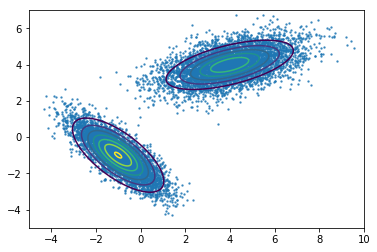

In [29]:
plt.contour(x,y, s_tot)
plt.scatter(samples[0], samples[1],alpha=0.7, s=2) # color=c, alpha=0.7, s=2)

## Noisy Sine

Now I do the same test of the algorithm, only using a non-linear data in a form of a circle. 

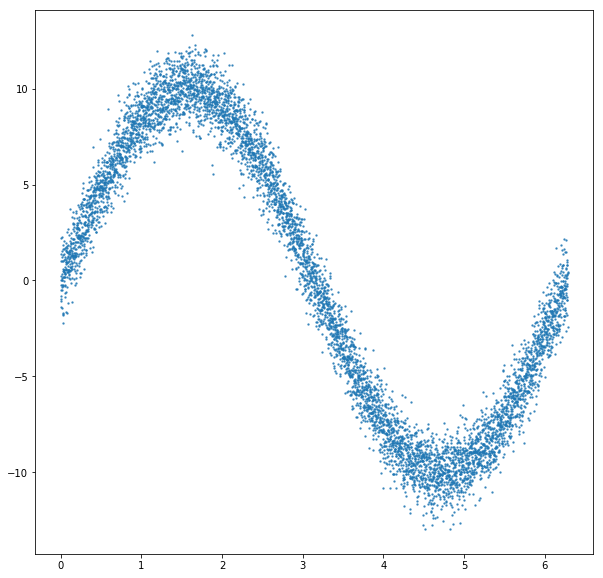

In [30]:
x = np.arange(0,2*np.pi,0.001)
y = 10*np.sin(x) + np.random.randn(x.size)
samples = np.array([[x],[y]]).reshape(2,x.shape[0])

fig = plt.figure(figsize=(10, 10))
plt.scatter(x, y,alpha=0.7, s=2)



In [31]:
vb_sin = mbpca.MVBPCA(samples, 10)
vb_sin.fit(5000,1000, eps=0.01, verbose=False, init=True)

 Iteration: 0
 Lower bound: -11971937.11
 Iteration: 1
 Lower bound: -61763.75
 Iteration: 2
 Lower bound: -57429.63
 Iteration: 3
 Lower bound: -54536.09
 Iteration: 4
 Lower bound: -52771.25
 Iteration: 5
 Lower bound: -51689.31
 Iteration: 6
 Lower bound: -50144.72
 Iteration: 7
 Lower bound: -48436.42
 Iteration: 8
 Lower bound: -46525.33
 Iteration: 9
 Lower bound: -44998.86
 Iteration: 10
 Lower bound: -43735.61
 Iteration: 11
 Lower bound: -42669.17
 Iteration: 12
 Lower bound: -41806.58
 Iteration: 13
 Lower bound: -41111.02
 Iteration: 14
 Lower bound: -40563.61
 Iteration: 15
 Lower bound: -40112.19
 Iteration: 16
 Lower bound: -39729.76
 Iteration: 17
 Lower bound: -39403.48
 Iteration: 18
 Lower bound: -39125.08
 Iteration: 19
 Lower bound: -38888.40
 Iteration: 20
 Lower bound: -38688.09
 Iteration: 21
 Lower bound: -38518.69
 Iteration: 22
 Lower bound: -38375.08
 Iteration: 23
 Lower bound: -38252.75
 Iteration: 24
 Lower bound: -38141.41
 Iteration: 25
 Lower bound: -38

 Iteration: 142
 Lower bound: -36591.45
 Iteration: 143
 Lower bound: -36585.52
 Iteration: 144
 Lower bound: -36579.58
 Iteration: 145
 Lower bound: -36573.65
 Iteration: 146
 Lower bound: -36567.72
 Iteration: 147
 Lower bound: -36561.78
 Iteration: 148
 Lower bound: -36555.84
 Iteration: 149
 Lower bound: -36549.90
 Iteration: 150
 Lower bound: -36543.96
 Iteration: 151
 Lower bound: -36538.01
 Iteration: 152
 Lower bound: -36532.07
 Iteration: 153
 Lower bound: -36526.12
 Iteration: 154
 Lower bound: -36520.17
 Iteration: 155
 Lower bound: -36514.21
 Iteration: 156
 Lower bound: -36508.26
 Iteration: 157
 Lower bound: -36502.30
 Iteration: 158
 Lower bound: -36496.35
 Iteration: 159
 Lower bound: -36490.39
 Iteration: 160
 Lower bound: -36484.43
 Iteration: 161
 Lower bound: -36478.46
 Iteration: 162
 Lower bound: -36472.50
 Iteration: 163
 Lower bound: -36466.53
 Iteration: 164
 Lower bound: -36460.56
 Iteration: 165
 Lower bound: -36454.59
 Iteration: 166
 Lower bound: -36448.62


 Lower bound: -35771.15
 Iteration: 279
 Lower bound: -35765.06
 Iteration: 280
 Lower bound: -35758.98
 Iteration: 281
 Lower bound: -35752.90
 Iteration: 282
 Lower bound: -35746.82
 Iteration: 283
 Lower bound: -35740.73
 Iteration: 284
 Lower bound: -35734.65
 Iteration: 285
 Lower bound: -35728.56
 Iteration: 286
 Lower bound: -35722.48
 Iteration: 287
 Lower bound: -35716.40
 Iteration: 288
 Lower bound: -35710.31
 Iteration: 289
 Lower bound: -35704.23
 Iteration: 290
 Lower bound: -35698.15
 Iteration: 291
 Lower bound: -35692.06
 Iteration: 292
 Lower bound: -35685.98
 Iteration: 293
 Lower bound: -35679.90
 Iteration: 294
 Lower bound: -35673.81
 Iteration: 295
 Lower bound: -35667.73
 Iteration: 296
 Lower bound: -35661.65
 Iteration: 297
 Lower bound: -35655.56
 Iteration: 298
 Lower bound: -35649.48
 Iteration: 299
 Lower bound: -35643.40
 Iteration: 300
 Lower bound: -35637.31
 Iteration: 301
 Lower bound: -35631.23
 Iteration: 302
 Lower bound: -35625.15
 Iteration: 303


 Iteration: 413
 Lower bound: -34956.25
 Iteration: 414
 Lower bound: -34950.32
 Iteration: 415
 Lower bound: -34944.39
 Iteration: 416
 Lower bound: -34938.46
 Iteration: 417
 Lower bound: -34932.54
 Iteration: 418
 Lower bound: -34926.62
 Iteration: 419
 Lower bound: -34920.70
 Iteration: 420
 Lower bound: -34914.79
 Iteration: 421
 Lower bound: -34908.87
 Iteration: 422
 Lower bound: -34902.96
 Iteration: 423
 Lower bound: -34897.05
 Iteration: 424
 Lower bound: -34891.15
 Iteration: 425
 Lower bound: -34885.24
 Iteration: 426
 Lower bound: -34879.34
 Iteration: 427
 Lower bound: -34873.44
 Iteration: 428
 Lower bound: -34867.54
 Iteration: 429
 Lower bound: -34861.64
 Iteration: 430
 Lower bound: -34855.75
 Iteration: 431
 Lower bound: -34849.86
 Iteration: 432
 Lower bound: -34843.97
 Iteration: 433
 Lower bound: -34838.09
 Iteration: 434
 Lower bound: -34832.21
 Iteration: 435
 Lower bound: -34826.33
 Iteration: 436
 Lower bound: -34820.45
 Iteration: 437
 Lower bound: -34814.58


 Iteration: 551
 Lower bound: -34163.35
 Iteration: 552
 Lower bound: -34157.81
 Iteration: 553
 Lower bound: -34152.28
 Iteration: 554
 Lower bound: -34146.75
 Iteration: 555
 Lower bound: -34141.23
 Iteration: 556
 Lower bound: -34135.71
 Iteration: 557
 Lower bound: -34130.19
 Iteration: 558
 Lower bound: -34124.68
 Iteration: 559
 Lower bound: -34119.17
 Iteration: 560
 Lower bound: -34113.66
 Iteration: 561
 Lower bound: -34108.15
 Iteration: 562
 Lower bound: -34102.65
 Iteration: 563
 Lower bound: -34097.15
 Iteration: 564
 Lower bound: -34091.65
 Iteration: 565
 Lower bound: -34086.16
 Iteration: 566
 Lower bound: -34080.67
 Iteration: 567
 Lower bound: -34075.18
 Iteration: 568
 Lower bound: -34069.69
 Iteration: 569
 Lower bound: -34064.21
 Iteration: 570
 Lower bound: -34058.74
 Iteration: 571
 Lower bound: -34053.26
 Iteration: 572
 Lower bound: -34047.79
 Iteration: 573
 Lower bound: -34042.32
 Iteration: 574
 Lower bound: -34036.86
 Iteration: 575
 Lower bound: -34031.40


 Iteration: 690
 Lower bound: -33427.60
 Iteration: 691
 Lower bound: -33422.57
 Iteration: 692
 Lower bound: -33417.53
 Iteration: 693
 Lower bound: -33412.50
 Iteration: 694
 Lower bound: -33407.48
 Iteration: 695
 Lower bound: -33402.45
 Iteration: 696
 Lower bound: -33397.44
 Iteration: 697
 Lower bound: -33392.42
 Iteration: 698
 Lower bound: -33387.41
 Iteration: 699
 Lower bound: -33382.41
 Iteration: 700
 Lower bound: -33377.40
 Iteration: 701
 Lower bound: -33372.41
 Iteration: 702
 Lower bound: -33367.41
 Iteration: 703
 Lower bound: -33362.42
 Iteration: 704
 Lower bound: -33357.43
 Iteration: 705
 Lower bound: -33352.45
 Iteration: 706
 Lower bound: -33347.46
 Iteration: 707
 Lower bound: -33342.49
 Iteration: 708
 Lower bound: -33337.51
 Iteration: 709
 Lower bound: -33332.54
 Iteration: 710
 Lower bound: -33327.58
 Iteration: 711
 Lower bound: -33322.61
 Iteration: 712
 Lower bound: -33317.66
 Iteration: 713
 Lower bound: -33312.70
 Iteration: 714
 Lower bound: -33307.75


 Iteration: 834
 Lower bound: -32742.62
 Iteration: 835
 Lower bound: -32738.18
 Iteration: 836
 Lower bound: -32733.73
 Iteration: 837
 Lower bound: -32729.29
 Iteration: 838
 Lower bound: -32724.85
 Iteration: 839
 Lower bound: -32720.42
 Iteration: 840
 Lower bound: -32715.99
 Iteration: 841
 Lower bound: -32711.57
 Iteration: 842
 Lower bound: -32707.15
 Iteration: 843
 Lower bound: -32702.74
 Iteration: 844
 Lower bound: -32698.33
 Iteration: 845
 Lower bound: -32693.92
 Iteration: 846
 Lower bound: -32689.52
 Iteration: 847
 Lower bound: -32685.13
 Iteration: 848
 Lower bound: -32680.74
 Iteration: 849
 Lower bound: -32676.36
 Iteration: 850
 Lower bound: -32671.98
 Iteration: 851
 Lower bound: -32667.60
 Iteration: 852
 Lower bound: -32663.23
 Iteration: 853
 Lower bound: -32658.86
 Iteration: 854
 Lower bound: -32654.50
 Iteration: 855
 Lower bound: -32650.14
 Iteration: 856
 Lower bound: -32645.78
 Iteration: 857
 Lower bound: -32641.43
 Iteration: 858
 Lower bound: -32637.09


 Iteration: 969
 Lower bound: -32187.05
 Iteration: 970
 Lower bound: -32183.31
 Iteration: 971
 Lower bound: -32179.58
 Iteration: 972
 Lower bound: -32175.85
 Iteration: 973
 Lower bound: -32172.13
 Iteration: 974
 Lower bound: -32168.42
 Iteration: 975
 Lower bound: -32164.71
 Iteration: 976
 Lower bound: -32161.01
 Iteration: 977
 Lower bound: -32157.31
 Iteration: 978
 Lower bound: -32153.62
 Iteration: 979
 Lower bound: -32149.94
 Iteration: 980
 Lower bound: -32146.26
 Iteration: 981
 Lower bound: -32142.59
 Iteration: 982
 Lower bound: -32138.92
 Iteration: 983
 Lower bound: -32135.27
 Iteration: 984
 Lower bound: -32131.61
 Iteration: 985
 Lower bound: -32127.97
 Iteration: 986
 Lower bound: -32124.33
 Iteration: 987
 Lower bound: -32120.69
 Iteration: 988
 Lower bound: -32117.07
 Iteration: 989
 Lower bound: -32113.45
 Iteration: 990
 Lower bound: -32109.83
 Iteration: 991
 Lower bound: -32106.22
 Iteration: 992
 Lower bound: -32102.62
 Iteration: 993
 Lower bound: -32099.02


 Iteration: 1104
 Lower bound: -31739.04
 Iteration: 1105
 Lower bound: -31736.16
 Iteration: 1106
 Lower bound: -31733.28
 Iteration: 1107
 Lower bound: -31730.41
 Iteration: 1108
 Lower bound: -31727.55
 Iteration: 1109
 Lower bound: -31724.69
 Iteration: 1110
 Lower bound: -31721.84
 Iteration: 1111
 Lower bound: -31719.00
 Iteration: 1112
 Lower bound: -31716.16
 Iteration: 1113
 Lower bound: -31713.33
 Iteration: 1114
 Lower bound: -31710.50
 Iteration: 1115
 Lower bound: -31707.68
 Iteration: 1116
 Lower bound: -31704.87
 Iteration: 1117
 Lower bound: -31702.06
 Iteration: 1118
 Lower bound: -31699.26
 Iteration: 1119
 Lower bound: -31696.47
 Iteration: 1120
 Lower bound: -31693.68
 Iteration: 1121
 Lower bound: -31690.90
 Iteration: 1122
 Lower bound: -31688.13
 Iteration: 1123
 Lower bound: -31685.36
 Iteration: 1124
 Lower bound: -31682.60
 Iteration: 1125
 Lower bound: -31679.85
 Iteration: 1126
 Lower bound: -31677.10
 Iteration: 1127
 Lower bound: -31674.36
 Iteration: 1128

 Iteration: 1248
 Lower bound: -31385.75
 Iteration: 1249
 Lower bound: -31383.70
 Iteration: 1250
 Lower bound: -31381.64
 Iteration: 1251
 Lower bound: -31379.60
 Iteration: 1252
 Lower bound: -31377.55
 Iteration: 1253
 Lower bound: -31375.51
 Iteration: 1254
 Lower bound: -31373.48
 Iteration: 1255
 Lower bound: -31371.45
 Iteration: 1256
 Lower bound: -31369.43
 Iteration: 1257
 Lower bound: -31367.41
 Iteration: 1258
 Lower bound: -31365.40
 Iteration: 1259
 Lower bound: -31363.39
 Iteration: 1260
 Lower bound: -31361.38
 Iteration: 1261
 Lower bound: -31359.38
 Iteration: 1262
 Lower bound: -31357.39
 Iteration: 1263
 Lower bound: -31355.39
 Iteration: 1264
 Lower bound: -31353.41
 Iteration: 1265
 Lower bound: -31351.43
 Iteration: 1266
 Lower bound: -31349.45
 Iteration: 1267
 Lower bound: -31347.48
 Iteration: 1268
 Lower bound: -31345.51
 Iteration: 1269
 Lower bound: -31343.54
 Iteration: 1270
 Lower bound: -31341.58
 Iteration: 1271
 Lower bound: -31339.63
 Iteration: 1272

 Iteration: 1381
 Lower bound: -31148.09
 Iteration: 1382
 Lower bound: -31146.53
 Iteration: 1383
 Lower bound: -31144.97
 Iteration: 1384
 Lower bound: -31143.42
 Iteration: 1385
 Lower bound: -31141.87
 Iteration: 1386
 Lower bound: -31140.32
 Iteration: 1387
 Lower bound: -31138.77
 Iteration: 1388
 Lower bound: -31137.23
 Iteration: 1389
 Lower bound: -31135.69
 Iteration: 1390
 Lower bound: -31134.15
 Iteration: 1391
 Lower bound: -31132.61
 Iteration: 1392
 Lower bound: -31131.08
 Iteration: 1393
 Lower bound: -31129.55
 Iteration: 1394
 Lower bound: -31128.02
 Iteration: 1395
 Lower bound: -31126.50
 Iteration: 1396
 Lower bound: -31124.97
 Iteration: 1397
 Lower bound: -31123.45
 Iteration: 1398
 Lower bound: -31121.93
 Iteration: 1399
 Lower bound: -31120.42
 Iteration: 1400
 Lower bound: -31118.91
 Iteration: 1401
 Lower bound: -31117.40
 Iteration: 1402
 Lower bound: -31115.89
 Iteration: 1403
 Lower bound: -31114.38
 Iteration: 1404
 Lower bound: -31112.88
 Iteration: 1405

 Iteration: 1520
 Lower bound: -30952.18
 Iteration: 1521
 Lower bound: -30950.89
 Iteration: 1522
 Lower bound: -30949.60
 Iteration: 1523
 Lower bound: -30948.32
 Iteration: 1524
 Lower bound: -30947.03
 Iteration: 1525
 Lower bound: -30945.75
 Iteration: 1526
 Lower bound: -30944.46
 Iteration: 1527
 Lower bound: -30943.18
 Iteration: 1528
 Lower bound: -30941.90
 Iteration: 1529
 Lower bound: -30940.62
 Iteration: 1530
 Lower bound: -30939.35
 Iteration: 1531
 Lower bound: -30938.07
 Iteration: 1532
 Lower bound: -30936.79
 Iteration: 1533
 Lower bound: -30935.52
 Iteration: 1534
 Lower bound: -30934.25
 Iteration: 1535
 Lower bound: -30932.98
 Iteration: 1536
 Lower bound: -30931.71
 Iteration: 1537
 Lower bound: -30930.44
 Iteration: 1538
 Lower bound: -30929.17
 Iteration: 1539
 Lower bound: -30927.90
 Iteration: 1540
 Lower bound: -30926.64
 Iteration: 1541
 Lower bound: -30925.37
 Iteration: 1542
 Lower bound: -30924.11
 Iteration: 1543
 Lower bound: -30922.85
 Iteration: 1544

 Iteration: 1660
 Lower bound: -30781.86
 Iteration: 1661
 Lower bound: -30780.70
 Iteration: 1662
 Lower bound: -30779.55
 Iteration: 1663
 Lower bound: -30778.39
 Iteration: 1664
 Lower bound: -30777.24
 Iteration: 1665
 Lower bound: -30776.08
 Iteration: 1666
 Lower bound: -30774.93
 Iteration: 1667
 Lower bound: -30773.78
 Iteration: 1668
 Lower bound: -30772.63
 Iteration: 1669
 Lower bound: -30771.48
 Iteration: 1670
 Lower bound: -30770.33
 Iteration: 1671
 Lower bound: -30769.18
 Iteration: 1672
 Lower bound: -30768.03
 Iteration: 1673
 Lower bound: -30766.88
 Iteration: 1674
 Lower bound: -30765.73
 Iteration: 1675
 Lower bound: -30764.59
 Iteration: 1676
 Lower bound: -30763.44
 Iteration: 1677
 Lower bound: -30762.29
 Iteration: 1678
 Lower bound: -30761.15
 Iteration: 1679
 Lower bound: -30760.01
 Iteration: 1680
 Lower bound: -30758.86
 Iteration: 1681
 Lower bound: -30757.72
 Iteration: 1682
 Lower bound: -30756.58
 Iteration: 1683
 Lower bound: -30755.43
 Iteration: 1684

 Iteration: 1795
 Lower bound: -30631.44
 Iteration: 1796
 Lower bound: -30630.36
 Iteration: 1797
 Lower bound: -30629.29
 Iteration: 1798
 Lower bound: -30628.22
 Iteration: 1799
 Lower bound: -30627.14
 Iteration: 1800
 Lower bound: -30626.07
 Iteration: 1801
 Lower bound: -30625.00
 Iteration: 1802
 Lower bound: -30623.93
 Iteration: 1803
 Lower bound: -30622.86
 Iteration: 1804
 Lower bound: -30621.79
 Iteration: 1805
 Lower bound: -30620.72
 Iteration: 1806
 Lower bound: -30619.65
 Iteration: 1807
 Lower bound: -30618.58
 Iteration: 1808
 Lower bound: -30617.51
 Iteration: 1809
 Lower bound: -30616.45
 Iteration: 1810
 Lower bound: -30615.38
 Iteration: 1811
 Lower bound: -30614.31
 Iteration: 1812
 Lower bound: -30613.25
 Iteration: 1813
 Lower bound: -30612.18
 Iteration: 1814
 Lower bound: -30611.12
 Iteration: 1815
 Lower bound: -30610.05
 Iteration: 1816
 Lower bound: -30608.99
 Iteration: 1817
 Lower bound: -30607.92
 Iteration: 1818
 Lower bound: -30606.86
 Iteration: 1819

 Iteration: 1932
 Lower bound: -30489.22
 Iteration: 1933
 Lower bound: -30488.21
 Iteration: 1934
 Lower bound: -30487.21
 Iteration: 1935
 Lower bound: -30486.21
 Iteration: 1936
 Lower bound: -30485.21
 Iteration: 1937
 Lower bound: -30484.21
 Iteration: 1938
 Lower bound: -30483.21
 Iteration: 1939
 Lower bound: -30482.21
 Iteration: 1940
 Lower bound: -30481.22
 Iteration: 1941
 Lower bound: -30480.22
 Iteration: 1942
 Lower bound: -30479.22
 Iteration: 1943
 Lower bound: -30478.23
 Iteration: 1944
 Lower bound: -30477.23
 Iteration: 1945
 Lower bound: -30476.23
 Iteration: 1946
 Lower bound: -30475.24
 Iteration: 1947
 Lower bound: -30474.24
 Iteration: 1948
 Lower bound: -30473.25
 Iteration: 1949
 Lower bound: -30472.26
 Iteration: 1950
 Lower bound: -30471.26
 Iteration: 1951
 Lower bound: -30470.27
 Iteration: 1952
 Lower bound: -30469.28
 Iteration: 1953
 Lower bound: -30468.29
 Iteration: 1954
 Lower bound: -30467.30
 Iteration: 1955
 Lower bound: -30466.31
 Iteration: 1956

 Iteration: 2070
 Lower bound: -30355.81
 Iteration: 2071
 Lower bound: -30354.88
 Iteration: 2072
 Lower bound: -30353.95
 Iteration: 2073
 Lower bound: -30353.02
 Iteration: 2074
 Lower bound: -30352.09
 Iteration: 2075
 Lower bound: -30351.16
 Iteration: 2076
 Lower bound: -30350.23
 Iteration: 2077
 Lower bound: -30349.30
 Iteration: 2078
 Lower bound: -30348.38
 Iteration: 2079
 Lower bound: -30347.45
 Iteration: 2080
 Lower bound: -30346.52
 Iteration: 2081
 Lower bound: -30345.60
 Iteration: 2082
 Lower bound: -30344.67
 Iteration: 2083
 Lower bound: -30343.74
 Iteration: 2084
 Lower bound: -30342.82
 Iteration: 2085
 Lower bound: -30341.90
 Iteration: 2086
 Lower bound: -30340.97
 Iteration: 2087
 Lower bound: -30340.05
 Iteration: 2088
 Lower bound: -30339.13
 Iteration: 2089
 Lower bound: -30338.20
 Iteration: 2090
 Lower bound: -30337.28
 Iteration: 2091
 Lower bound: -30336.36
 Iteration: 2092
 Lower bound: -30335.44
 Iteration: 2093
 Lower bound: -30334.52
 Iteration: 2094

 Lower bound: -30227.06
 Iteration: 2215
 Lower bound: -30226.21
 Iteration: 2216
 Lower bound: -30225.35
 Iteration: 2217
 Lower bound: -30224.50
 Iteration: 2218
 Lower bound: -30223.64
 Iteration: 2219
 Lower bound: -30222.79
 Iteration: 2220
 Lower bound: -30221.94
 Iteration: 2221
 Lower bound: -30221.08
 Iteration: 2222
 Lower bound: -30220.23
 Iteration: 2223
 Lower bound: -30219.38
 Iteration: 2224
 Lower bound: -30218.53
 Iteration: 2225
 Lower bound: -30217.68
 Iteration: 2226
 Lower bound: -30216.83
 Iteration: 2227
 Lower bound: -30215.98
 Iteration: 2228
 Lower bound: -30215.13
 Iteration: 2229
 Lower bound: -30214.28
 Iteration: 2230
 Lower bound: -30213.43
 Iteration: 2231
 Lower bound: -30212.58
 Iteration: 2232
 Lower bound: -30211.74
 Iteration: 2233
 Lower bound: -30210.89
 Iteration: 2234
 Lower bound: -30210.04
 Iteration: 2235
 Lower bound: -30209.20
 Iteration: 2236
 Lower bound: -30208.35
 Iteration: 2237
 Lower bound: -30207.51
 Iteration: 2238
 Lower bound: -3

 Iteration: 2350
 Lower bound: -30115.46
 Iteration: 2351
 Lower bound: -30114.67
 Iteration: 2352
 Lower bound: -30113.89
 Iteration: 2353
 Lower bound: -30113.11
 Iteration: 2354
 Lower bound: -30112.32
 Iteration: 2355
 Lower bound: -30111.54
 Iteration: 2356
 Lower bound: -30110.76
 Iteration: 2357
 Lower bound: -30109.98
 Iteration: 2358
 Lower bound: -30109.20
 Iteration: 2359
 Lower bound: -30108.42
 Iteration: 2360
 Lower bound: -30107.64
 Iteration: 2361
 Lower bound: -30106.86
 Iteration: 2362
 Lower bound: -30106.09
 Iteration: 2363
 Lower bound: -30105.31
 Iteration: 2364
 Lower bound: -30104.53
 Iteration: 2365
 Lower bound: -30103.76
 Iteration: 2366
 Lower bound: -30102.98
 Iteration: 2367
 Lower bound: -30102.20
 Iteration: 2368
 Lower bound: -30101.43
 Iteration: 2369
 Lower bound: -30100.66
 Iteration: 2370
 Lower bound: -30099.88
 Iteration: 2371
 Lower bound: -30099.11
 Iteration: 2372
 Lower bound: -30098.34
 Iteration: 2373
 Lower bound: -30097.56
 Iteration: 2374

 Iteration: 2490
 Lower bound: -30010.95
 Iteration: 2491
 Lower bound: -30010.24
 Iteration: 2492
 Lower bound: -30009.54
 Iteration: 2493
 Lower bound: -30008.83
 Iteration: 2494
 Lower bound: -30008.12
 Iteration: 2495
 Lower bound: -30007.42
 Iteration: 2496
 Lower bound: -30006.71
 Iteration: 2497
 Lower bound: -30006.00
 Iteration: 2498
 Lower bound: -30005.30
 Iteration: 2499
 Lower bound: -30004.59
 Iteration: 2500
 Lower bound: -30003.89
 Iteration: 2501
 Lower bound: -30003.19
 Iteration: 2502
 Lower bound: -30002.49
 Iteration: 2503
 Lower bound: -30001.78
 Iteration: 2504
 Lower bound: -30001.08
 Iteration: 2505
 Lower bound: -30000.38
 Iteration: 2506
 Lower bound: -29999.68
 Iteration: 2507
 Lower bound: -29998.98
 Iteration: 2508
 Lower bound: -29998.28
 Iteration: 2509
 Lower bound: -29997.58
 Iteration: 2510
 Lower bound: -29996.88
 Iteration: 2511
 Lower bound: -29996.19
 Iteration: 2512
 Lower bound: -29995.49
 Iteration: 2513
 Lower bound: -29994.79
 Iteration: 2514

 Iteration: 2623
 Lower bound: -29921.41
 Iteration: 2624
 Lower bound: -29920.77
 Iteration: 2625
 Lower bound: -29920.13
 Iteration: 2626
 Lower bound: -29919.50
 Iteration: 2627
 Lower bound: -29918.86
 Iteration: 2628
 Lower bound: -29918.23
 Iteration: 2629
 Lower bound: -29917.59
 Iteration: 2630
 Lower bound: -29916.96
 Iteration: 2631
 Lower bound: -29916.32
 Iteration: 2632
 Lower bound: -29915.69
 Iteration: 2633
 Lower bound: -29915.05
 Iteration: 2634
 Lower bound: -29914.42
 Iteration: 2635
 Lower bound: -29913.79
 Iteration: 2636
 Lower bound: -29913.16
 Iteration: 2637
 Lower bound: -29912.53
 Iteration: 2638
 Lower bound: -29911.90
 Iteration: 2639
 Lower bound: -29911.27
 Iteration: 2640
 Lower bound: -29910.64
 Iteration: 2641
 Lower bound: -29910.01
 Iteration: 2642
 Lower bound: -29909.38
 Iteration: 2643
 Lower bound: -29908.75
 Iteration: 2644
 Lower bound: -29908.12
 Iteration: 2645
 Lower bound: -29907.50
 Iteration: 2646
 Lower bound: -29906.87
 Iteration: 2647

 Iteration: 2769
 Lower bound: -29833.81
 Iteration: 2770
 Lower bound: -29833.25
 Iteration: 2771
 Lower bound: -29832.69
 Iteration: 2772
 Lower bound: -29832.13
 Iteration: 2773
 Lower bound: -29831.57
 Iteration: 2774
 Lower bound: -29831.01
 Iteration: 2775
 Lower bound: -29830.45
 Iteration: 2776
 Lower bound: -29829.89
 Iteration: 2777
 Lower bound: -29829.33
 Iteration: 2778
 Lower bound: -29828.78
 Iteration: 2779
 Lower bound: -29828.22
 Iteration: 2780
 Lower bound: -29827.66
 Iteration: 2781
 Lower bound: -29827.11
 Iteration: 2782
 Lower bound: -29826.55
 Iteration: 2783
 Lower bound: -29826.00
 Iteration: 2784
 Lower bound: -29825.44
 Iteration: 2785
 Lower bound: -29824.89
 Iteration: 2786
 Lower bound: -29824.33
 Iteration: 2787
 Lower bound: -29823.78
 Iteration: 2788
 Lower bound: -29823.23
 Iteration: 2789
 Lower bound: -29822.68
 Iteration: 2790
 Lower bound: -29822.12
 Iteration: 2791
 Lower bound: -29821.57
 Iteration: 2792
 Lower bound: -29821.02
 Iteration: 2793

 Lower bound: -29759.58
 Iteration: 2911
 Lower bound: -29759.09
 Iteration: 2912
 Lower bound: -29758.59
 Iteration: 2913
 Lower bound: -29758.10
 Iteration: 2914
 Lower bound: -29757.61
 Iteration: 2915
 Lower bound: -29757.12
 Iteration: 2916
 Lower bound: -29756.64
 Iteration: 2917
 Lower bound: -29756.15
 Iteration: 2918
 Lower bound: -29755.66
 Iteration: 2919
 Lower bound: -29755.17
 Iteration: 2920
 Lower bound: -29754.68
 Iteration: 2921
 Lower bound: -29754.20
 Iteration: 2922
 Lower bound: -29753.71
 Iteration: 2923
 Lower bound: -29753.23
 Iteration: 2924
 Lower bound: -29752.74
 Iteration: 2925
 Lower bound: -29752.26
 Iteration: 2926
 Lower bound: -29751.77
 Iteration: 2927
 Lower bound: -29751.29
 Iteration: 2928
 Lower bound: -29750.81
 Iteration: 2929
 Lower bound: -29750.32
 Iteration: 2930
 Lower bound: -29749.84
 Iteration: 2931
 Lower bound: -29749.36
 Iteration: 2932
 Lower bound: -29748.88
 Iteration: 2933
 Lower bound: -29748.40
 Iteration: 2934
 Lower bound: -2

 Iteration: 3043
 Lower bound: -29698.42
 Iteration: 3044
 Lower bound: -29697.99
 Iteration: 3045
 Lower bound: -29697.56
 Iteration: 3046
 Lower bound: -29697.13
 Iteration: 3047
 Lower bound: -29696.71
 Iteration: 3048
 Lower bound: -29696.28
 Iteration: 3049
 Lower bound: -29695.85
 Iteration: 3050
 Lower bound: -29695.43
 Iteration: 3051
 Lower bound: -29695.00
 Iteration: 3052
 Lower bound: -29694.58
 Iteration: 3053
 Lower bound: -29694.15
 Iteration: 3054
 Lower bound: -29693.73
 Iteration: 3055
 Lower bound: -29693.31
 Iteration: 3056
 Lower bound: -29692.88
 Iteration: 3057
 Lower bound: -29692.46
 Iteration: 3058
 Lower bound: -29692.04
 Iteration: 3059
 Lower bound: -29691.62
 Iteration: 3060
 Lower bound: -29691.20
 Iteration: 3061
 Lower bound: -29690.78
 Iteration: 3062
 Lower bound: -29690.35
 Iteration: 3063
 Lower bound: -29689.94
 Iteration: 3064
 Lower bound: -29689.52
 Iteration: 3065
 Lower bound: -29689.10
 Iteration: 3066
 Lower bound: -29688.68
 Iteration: 3067

 Iteration: 3185
 Lower bound: -29642.03
 Iteration: 3186
 Lower bound: -29641.66
 Iteration: 3187
 Lower bound: -29641.30
 Iteration: 3188
 Lower bound: -29640.93
 Iteration: 3189
 Lower bound: -29640.56
 Iteration: 3190
 Lower bound: -29640.20
 Iteration: 3191
 Lower bound: -29639.84
 Iteration: 3192
 Lower bound: -29639.47
 Iteration: 3193
 Lower bound: -29639.11
 Iteration: 3194
 Lower bound: -29638.75
 Iteration: 3195
 Lower bound: -29638.38
 Iteration: 3196
 Lower bound: -29638.02
 Iteration: 3197
 Lower bound: -29637.66
 Iteration: 3198
 Lower bound: -29637.30
 Iteration: 3199
 Lower bound: -29636.94
 Iteration: 3200
 Lower bound: -29636.58
 Iteration: 3201
 Lower bound: -29636.22
 Iteration: 3202
 Lower bound: -29635.86
 Iteration: 3203
 Lower bound: -29635.50
 Iteration: 3204
 Lower bound: -29635.14
 Iteration: 3205
 Lower bound: -29634.78
 Iteration: 3206
 Lower bound: -29634.42
 Iteration: 3207
 Lower bound: -29634.07
 Iteration: 3208
 Lower bound: -29633.71
 Iteration: 3209

 Iteration: 3329
 Lower bound: -29593.49
 Iteration: 3330
 Lower bound: -29593.18
 Iteration: 3331
 Lower bound: -29592.87
 Iteration: 3332
 Lower bound: -29592.57
 Iteration: 3333
 Lower bound: -29592.26
 Iteration: 3334
 Lower bound: -29591.95
 Iteration: 3335
 Lower bound: -29591.65
 Iteration: 3336
 Lower bound: -29591.34
 Iteration: 3337
 Lower bound: -29591.03
 Iteration: 3338
 Lower bound: -29590.73
 Iteration: 3339
 Lower bound: -29590.42
 Iteration: 3340
 Lower bound: -29590.12
 Iteration: 3341
 Lower bound: -29589.81
 Iteration: 3342
 Lower bound: -29589.51
 Iteration: 3343
 Lower bound: -29589.21
 Iteration: 3344
 Lower bound: -29588.90
 Iteration: 3345
 Lower bound: -29588.60
 Iteration: 3346
 Lower bound: -29588.30
 Iteration: 3347
 Lower bound: -29588.00
 Iteration: 3348
 Lower bound: -29587.69
 Iteration: 3349
 Lower bound: -29587.39
 Iteration: 3350
 Lower bound: -29587.09
 Iteration: 3351
 Lower bound: -29586.79
 Iteration: 3352
 Lower bound: -29586.49
 Iteration: 3353

 Iteration: 3473
 Lower bound: -29552.82
 Iteration: 3474
 Lower bound: -29552.57
 Iteration: 3475
 Lower bound: -29552.31
 Iteration: 3476
 Lower bound: -29552.05
 Iteration: 3477
 Lower bound: -29551.80
 Iteration: 3478
 Lower bound: -29551.54
 Iteration: 3479
 Lower bound: -29551.29
 Iteration: 3480
 Lower bound: -29551.03
 Iteration: 3481
 Lower bound: -29550.78
 Iteration: 3482
 Lower bound: -29550.52
 Iteration: 3483
 Lower bound: -29550.27
 Iteration: 3484
 Lower bound: -29550.01
 Iteration: 3485
 Lower bound: -29549.76
 Iteration: 3486
 Lower bound: -29549.51
 Iteration: 3487
 Lower bound: -29549.25
 Iteration: 3488
 Lower bound: -29549.00
 Iteration: 3489
 Lower bound: -29548.75
 Iteration: 3490
 Lower bound: -29548.50
 Iteration: 3491
 Lower bound: -29548.25
 Iteration: 3492
 Lower bound: -29548.00
 Iteration: 3493
 Lower bound: -29547.75
 Iteration: 3494
 Lower bound: -29547.50
 Iteration: 3495
 Lower bound: -29547.25
 Iteration: 3496
 Lower bound: -29547.00
 Iteration: 3497

 Iteration: 3615
 Lower bound: -29519.55
 Iteration: 3616
 Lower bound: -29519.34
 Iteration: 3617
 Lower bound: -29519.13
 Iteration: 3618
 Lower bound: -29518.92
 Iteration: 3619
 Lower bound: -29518.70
 Iteration: 3620
 Lower bound: -29518.49
 Iteration: 3621
 Lower bound: -29518.28
 Iteration: 3622
 Lower bound: -29518.07
 Iteration: 3623
 Lower bound: -29517.86
 Iteration: 3624
 Lower bound: -29517.65
 Iteration: 3625
 Lower bound: -29517.44
 Iteration: 3626
 Lower bound: -29517.23
 Iteration: 3627
 Lower bound: -29517.02
 Iteration: 3628
 Lower bound: -29516.82
 Iteration: 3629
 Lower bound: -29516.61
 Iteration: 3630
 Lower bound: -29516.40
 Iteration: 3631
 Lower bound: -29516.19
 Iteration: 3632
 Lower bound: -29515.98
 Iteration: 3633
 Lower bound: -29515.78
 Iteration: 3634
 Lower bound: -29515.57
 Iteration: 3635
 Lower bound: -29515.36
 Iteration: 3636
 Lower bound: -29515.16
 Iteration: 3637
 Lower bound: -29514.95
 Iteration: 3638
 Lower bound: -29514.74
 Iteration: 3639

 Iteration: 3752
 Lower bound: -29493.10
 Iteration: 3753
 Lower bound: -29492.92
 Iteration: 3754
 Lower bound: -29492.75
 Iteration: 3755
 Lower bound: -29492.57
 Iteration: 3756
 Lower bound: -29492.40
 Iteration: 3757
 Lower bound: -29492.23
 Iteration: 3758
 Lower bound: -29492.05
 Iteration: 3759
 Lower bound: -29491.88
 Iteration: 3760
 Lower bound: -29491.71
 Iteration: 3761
 Lower bound: -29491.53
 Iteration: 3762
 Lower bound: -29491.36
 Iteration: 3763
 Lower bound: -29491.19
 Iteration: 3764
 Lower bound: -29491.02
 Iteration: 3765
 Lower bound: -29490.85
 Iteration: 3766
 Lower bound: -29490.67
 Iteration: 3767
 Lower bound: -29490.50
 Iteration: 3768
 Lower bound: -29490.33
 Iteration: 3769
 Lower bound: -29490.16
 Iteration: 3770
 Lower bound: -29489.99
 Iteration: 3771
 Lower bound: -29489.82
 Iteration: 3772
 Lower bound: -29489.65
 Iteration: 3773
 Lower bound: -29489.48
 Iteration: 3774
 Lower bound: -29489.31
 Iteration: 3775
 Lower bound: -29489.14
 Iteration: 3776

 Iteration: 3889
 Lower bound: -29471.42
 Iteration: 3890
 Lower bound: -29471.28
 Iteration: 3891
 Lower bound: -29471.14
 Iteration: 3892
 Lower bound: -29470.99
 Iteration: 3893
 Lower bound: -29470.85
 Iteration: 3894
 Lower bound: -29470.71
 Iteration: 3895
 Lower bound: -29470.57
 Iteration: 3896
 Lower bound: -29470.43
 Iteration: 3897
 Lower bound: -29470.29
 Iteration: 3898
 Lower bound: -29470.15
 Iteration: 3899
 Lower bound: -29470.00
 Iteration: 3900
 Lower bound: -29469.86
 Iteration: 3901
 Lower bound: -29469.72
 Iteration: 3902
 Lower bound: -29469.58
 Iteration: 3903
 Lower bound: -29469.44
 Iteration: 3904
 Lower bound: -29469.30
 Iteration: 3905
 Lower bound: -29469.17
 Iteration: 3906
 Lower bound: -29469.03
 Iteration: 3907
 Lower bound: -29468.89
 Iteration: 3908
 Lower bound: -29468.75
 Iteration: 3909
 Lower bound: -29468.61
 Iteration: 3910
 Lower bound: -29468.47
 Iteration: 3911
 Lower bound: -29468.33
 Iteration: 3912
 Lower bound: -29468.20
 Iteration: 3913

 Iteration: 4027
 Lower bound: -29453.68
 Iteration: 4028
 Lower bound: -29453.56
 Iteration: 4029
 Lower bound: -29453.45
 Iteration: 4030
 Lower bound: -29453.33
 Iteration: 4031
 Lower bound: -29453.22
 Iteration: 4032
 Lower bound: -29453.10
 Iteration: 4033
 Lower bound: -29452.99
 Iteration: 4034
 Lower bound: -29452.87
 Iteration: 4035
 Lower bound: -29452.76
 Iteration: 4036
 Lower bound: -29452.65
 Iteration: 4037
 Lower bound: -29452.53
 Iteration: 4038
 Lower bound: -29452.42
 Iteration: 4039
 Lower bound: -29452.30
 Iteration: 4040
 Lower bound: -29452.19
 Iteration: 4041
 Lower bound: -29452.08
 Iteration: 4042
 Lower bound: -29451.97
 Iteration: 4043
 Lower bound: -29451.85
 Iteration: 4044
 Lower bound: -29451.74
 Iteration: 4045
 Lower bound: -29451.63
 Iteration: 4046
 Lower bound: -29451.52
 Iteration: 4047
 Lower bound: -29451.40
 Iteration: 4048
 Lower bound: -29451.29
 Iteration: 4049
 Lower bound: -29451.18
 Iteration: 4050
 Lower bound: -29451.07
 Iteration: 4051

 Iteration: 4164
 Lower bound: -29439.49
 Iteration: 4165
 Lower bound: -29439.39
 Iteration: 4166
 Lower bound: -29439.30
 Iteration: 4167
 Lower bound: -29439.21
 Iteration: 4168
 Lower bound: -29439.12
 Iteration: 4169
 Lower bound: -29439.03
 Iteration: 4170
 Lower bound: -29438.93
 Iteration: 4171
 Lower bound: -29438.84
 Iteration: 4172
 Lower bound: -29438.75
 Iteration: 4173
 Lower bound: -29438.66
 Iteration: 4174
 Lower bound: -29438.57
 Iteration: 4175
 Lower bound: -29438.48
 Iteration: 4176
 Lower bound: -29438.39
 Iteration: 4177
 Lower bound: -29438.30
 Iteration: 4178
 Lower bound: -29438.21
 Iteration: 4179
 Lower bound: -29438.12
 Iteration: 4180
 Lower bound: -29438.03
 Iteration: 4181
 Lower bound: -29437.94
 Iteration: 4182
 Lower bound: -29437.85
 Iteration: 4183
 Lower bound: -29437.76
 Iteration: 4184
 Lower bound: -29437.67
 Iteration: 4185
 Lower bound: -29437.58
 Iteration: 4186
 Lower bound: -29437.49
 Iteration: 4187
 Lower bound: -29437.40
 Iteration: 4188

 Iteration: 4304
 Lower bound: -29427.92
 Iteration: 4305
 Lower bound: -29427.85
 Iteration: 4306
 Lower bound: -29427.77
 Iteration: 4307
 Lower bound: -29427.70
 Iteration: 4308
 Lower bound: -29427.63
 Iteration: 4309
 Lower bound: -29427.55
 Iteration: 4310
 Lower bound: -29427.48
 Iteration: 4311
 Lower bound: -29427.41
 Iteration: 4312
 Lower bound: -29427.34
 Iteration: 4313
 Lower bound: -29427.26
 Iteration: 4314
 Lower bound: -29427.19
 Iteration: 4315
 Lower bound: -29427.12
 Iteration: 4316
 Lower bound: -29427.05
 Iteration: 4317
 Lower bound: -29426.98
 Iteration: 4318
 Lower bound: -29426.90
 Iteration: 4319
 Lower bound: -29426.83
 Iteration: 4320
 Lower bound: -29426.76
 Iteration: 4321
 Lower bound: -29426.69
 Iteration: 4322
 Lower bound: -29426.62
 Iteration: 4323
 Lower bound: -29426.55
 Iteration: 4324
 Lower bound: -29426.48
 Iteration: 4325
 Lower bound: -29426.40
 Iteration: 4326
 Lower bound: -29426.33
 Iteration: 4327
 Lower bound: -29426.26
 Iteration: 4328

 Iteration: 4444
 Lower bound: -29418.76
 Iteration: 4445
 Lower bound: -29418.70
 Iteration: 4446
 Lower bound: -29418.64
 Iteration: 4447
 Lower bound: -29418.59
 Iteration: 4448
 Lower bound: -29418.53
 Iteration: 4449
 Lower bound: -29418.47
 Iteration: 4450
 Lower bound: -29418.41
 Iteration: 4451
 Lower bound: -29418.36
 Iteration: 4452
 Lower bound: -29418.30
 Iteration: 4453
 Lower bound: -29418.24
 Iteration: 4454
 Lower bound: -29418.19
 Iteration: 4455
 Lower bound: -29418.13
 Iteration: 4456
 Lower bound: -29418.07
 Iteration: 4457
 Lower bound: -29418.01
 Iteration: 4458
 Lower bound: -29417.96
 Iteration: 4459
 Lower bound: -29417.90
 Iteration: 4460
 Lower bound: -29417.84
 Iteration: 4461
 Lower bound: -29417.79
 Iteration: 4462
 Lower bound: -29417.73
 Iteration: 4463
 Lower bound: -29417.68
 Iteration: 4464
 Lower bound: -29417.62
 Iteration: 4465
 Lower bound: -29417.56
 Iteration: 4466
 Lower bound: -29417.51
 Iteration: 4467
 Lower bound: -29417.45
 Iteration: 4468

 Iteration: 4583
 Lower bound: -29411.60
 Iteration: 4584
 Lower bound: -29411.55
 Iteration: 4585
 Lower bound: -29411.51
 Iteration: 4586
 Lower bound: -29411.46
 Iteration: 4587
 Lower bound: -29411.42
 Iteration: 4588
 Lower bound: -29411.37
 Iteration: 4589
 Lower bound: -29411.33
 Iteration: 4590
 Lower bound: -29411.28
 Iteration: 4591
 Lower bound: -29411.24
 Iteration: 4592
 Lower bound: -29411.20
 Iteration: 4593
 Lower bound: -29411.15
 Iteration: 4594
 Lower bound: -29411.11
 Iteration: 4595
 Lower bound: -29411.06
 Iteration: 4596
 Lower bound: -29411.02
 Iteration: 4597
 Lower bound: -29410.97
 Iteration: 4598
 Lower bound: -29410.93
 Iteration: 4599
 Lower bound: -29410.89
 Iteration: 4600
 Lower bound: -29410.84
 Iteration: 4601
 Lower bound: -29410.80
 Iteration: 4602
 Lower bound: -29410.75
 Iteration: 4603
 Lower bound: -29410.71
 Iteration: 4604
 Lower bound: -29410.67
 Iteration: 4605
 Lower bound: -29410.62
 Iteration: 4606
 Lower bound: -29410.58
 Iteration: 4607

 Iteration: 4721
 Lower bound: -29406.03
 Iteration: 4722
 Lower bound: -29405.99
 Iteration: 4723
 Lower bound: -29405.96
 Iteration: 4724
 Lower bound: -29405.92
 Iteration: 4725
 Lower bound: -29405.88
 Iteration: 4726
 Lower bound: -29405.85
 Iteration: 4727
 Lower bound: -29405.81
 Iteration: 4728
 Lower bound: -29405.78
 Iteration: 4729
 Lower bound: -29405.74
 Iteration: 4730
 Lower bound: -29405.71
 Iteration: 4731
 Lower bound: -29405.67
 Iteration: 4732
 Lower bound: -29405.64
 Iteration: 4733
 Lower bound: -29405.60
 Iteration: 4734
 Lower bound: -29405.57
 Iteration: 4735
 Lower bound: -29405.53
 Iteration: 4736
 Lower bound: -29405.50
 Iteration: 4737
 Lower bound: -29405.46
 Iteration: 4738
 Lower bound: -29405.43
 Iteration: 4739
 Lower bound: -29405.39
 Iteration: 4740
 Lower bound: -29405.36
 Iteration: 4741
 Lower bound: -29405.32
 Iteration: 4742
 Lower bound: -29405.29
 Iteration: 4743
 Lower bound: -29405.25
 Iteration: 4744
 Lower bound: -29405.22
 Iteration: 4745

 Iteration: 4855
 Lower bound: -29401.76
 Iteration: 4856
 Lower bound: -29401.74
 Iteration: 4857
 Lower bound: -29401.71
 Iteration: 4858
 Lower bound: -29401.68
 Iteration: 4859
 Lower bound: -29401.65
 Iteration: 4860
 Lower bound: -29401.62
 Iteration: 4861
 Lower bound: -29401.60
 Iteration: 4862
 Lower bound: -29401.57
 Iteration: 4863
 Lower bound: -29401.54
 Iteration: 4864
 Lower bound: -29401.51
 Iteration: 4865
 Lower bound: -29401.49
 Iteration: 4866
 Lower bound: -29401.46
 Iteration: 4867
 Lower bound: -29401.43
 Iteration: 4868
 Lower bound: -29401.40
 Iteration: 4869
 Lower bound: -29401.38
 Iteration: 4870
 Lower bound: -29401.35
 Iteration: 4871
 Lower bound: -29401.32
 Iteration: 4872
 Lower bound: -29401.29
 Iteration: 4873
 Lower bound: -29401.27
 Iteration: 4874
 Lower bound: -29401.24
 Iteration: 4875
 Lower bound: -29401.21
 Iteration: 4876
 Lower bound: -29401.19
 Iteration: 4877
 Lower bound: -29401.16
 Iteration: 4878
 Lower bound: -29401.13
 Iteration: 4879

 Iteration: 4993
 Lower bound: -29398.35
 Iteration: 4994
 Lower bound: -29398.33
 Iteration: 4995
 Lower bound: -29398.31
 Iteration: 4996
 Lower bound: -29398.28
 Iteration: 4997
 Lower bound: -29398.26
 Iteration: 4998
 Lower bound: -29398.24
 Iteration: 4999
 Lower bound: -29398.22


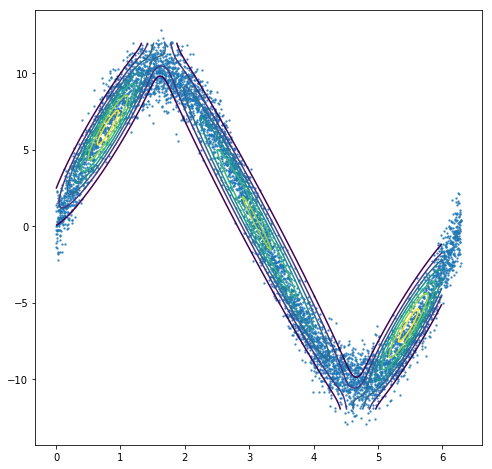

In [33]:
(x, y, s_tot) = create_contours(vb_sin,0,6,-12,12, 8, 8)
plt.contour(x,y, s_tot)
plt.scatter(samples[0], samples[1],alpha=0.7, s=2) # color=c, alpha=0.7, s=2)

In [34]:
print(['%0.2f %%' % (pi*100) for pi in vb_sin.q_pi.e_pi])

['0.00 %', '0.00 %', '0.00 %', '25.57 %', '0.00 %', '0.00 %', '48.77 %', '25.66 %', '0.00 %', '0.00 %']


## Circular Data

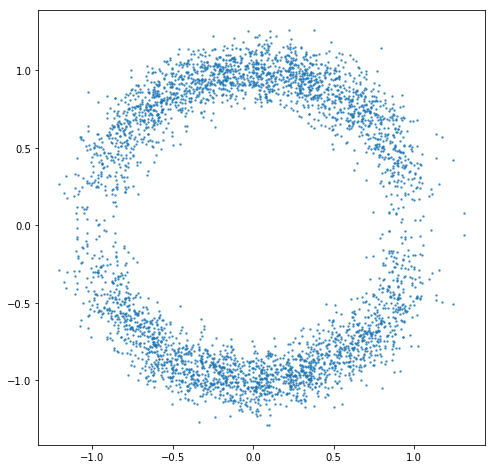

In [35]:
from sklearn import manifold, datasets

pi = np.array([30, 30, 30, 30]) / 120 # , 30, 30]) / (120)
mean = np.array([[0, 2], [0, -2], [2,0],[-2, 0]])
cov = np.array([[[0.5, 0],[0, 0.05]],[[0.5, 0],[0, 0.05]], [[0.05, 0],[0, 0.5]], [[0.05, 0],[0, 0.5]]])

samples, category = sample(pi, mean, cov, 1000)

x = np.arange(-1,1,0.001)
y1 = np.sqrt(1-x**2)
x+=np.random.randn(x.size)/10
y2 = -y1
y1 += np.random.randn(y1.size) / 10
y2 += np.random.randn(y2.size) / 10

x = np.tile(x,2)
y = np.append(y1,y2)
samples = np.array([[x],[y]]).reshape(2,x.shape[0])

fig = plt.figure(figsize=(8, 8))
plt.scatter(x, y,alpha=0.7, s=2) # color=c, alpha=0.7, s=2)

In [40]:
vb_circ = mbpca.MVBPCA(samples, 10)
vb_circ.fit(4000,0,eps=0.01, verbose=True, init=True)

 Iteration: 0
 Lower bound: -7642340.12
 Iteration: 1
 Lower bound: -36184.31
 Iteration: 2
 Lower bound: -22528.93
 Iteration: 3
 Lower bound: -20630.19
 Iteration: 4
 Lower bound: -20096.31
 Iteration: 5
 Lower bound: -19769.68
 Iteration: 6
 Lower bound: -19424.81
 Iteration: 7
 Lower bound: -19042.97
 Iteration: 8
 Lower bound: -18589.24
 Iteration: 9
 Lower bound: -17998.20
 Iteration: 10
 Lower bound: -17193.91
 Iteration: 11
 Lower bound: -16124.67
 Iteration: 12
 Lower bound: -14906.40
 Iteration: 13
 Lower bound: -13742.80
 Iteration: 14
 Lower bound: -12749.64
 Iteration: 15
 Lower bound: -11950.62
 Iteration: 16
 Lower bound: -11321.34
 Iteration: 17
 Lower bound: -10837.01
 Iteration: 18
 Lower bound: -10477.09
 Iteration: 19
 Lower bound: -10223.98
 Iteration: 20
 Lower bound: -10053.65
 Iteration: 21
 Lower bound: -9939.61
 Iteration: 22
 Lower bound: -9862.47
 Iteration: 23
 Lower bound: -9809.48
 Iteration: 24
 Lower bound: -9772.86
 Iteration: 25
 Lower bound: -9744.84

 Iteration: 142
 Lower bound: -9019.42
 Iteration: 143
 Lower bound: -9017.71
 Iteration: 144
 Lower bound: -9016.01
 Iteration: 145
 Lower bound: -9014.21
 Iteration: 146
 Lower bound: -9012.49
 Iteration: 147
 Lower bound: -9010.86
 Iteration: 148
 Lower bound: -9009.24
 Iteration: 149
 Lower bound: -9007.76
 Iteration: 150
 Lower bound: -9006.13
 Iteration: 151
 Lower bound: -9004.64
 Iteration: 152
 Lower bound: -9003.20
 Iteration: 153
 Lower bound: -9001.94
 Iteration: 154
 Lower bound: -9000.83
 Iteration: 155
 Lower bound: -8999.80
 Iteration: 156
 Lower bound: -8998.83
 Iteration: 157
 Lower bound: -8997.94
 Iteration: 158
 Lower bound: -8997.19
 Iteration: 159
 Lower bound: -8996.56
 Iteration: 160
 Lower bound: -8996.05
 Iteration: 161
 Lower bound: -8995.65
 Iteration: 162
 Lower bound: -8995.34
 Iteration: 163
 Lower bound: -8995.12
 Iteration: 164
 Lower bound: -8994.94
 Iteration: 165
 Lower bound: -8994.80
 Iteration: 166
 Lower bound: -8994.69
 Iteration: 167
 Lower bo

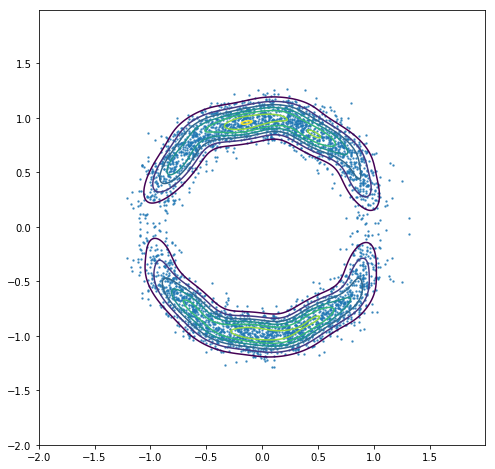

In [41]:
(x, y, s_tot) = create_contours(vb_circ,-2,2,-2,2, 8,8)
plt.contour(x,y, s_tot)
plt.scatter(samples[0], samples[1],alpha=0.7, s=2) # color=c, alpha=0.7, s=2)
plt.savefig('test.pdf', bbox_inches='tight')

In [42]:
print(['%0.2f %%' % (pi*100) for pi in vb_circ.q_pi.e_pi])

['15.36 %', '14.35 %', '5.45 %', '5.41 %', '3.05 %', '11.91 %', '18.48 %', '14.52 %', '0.00 %', '11.48 %']
